# Makes a plot of observed geostrophic currentsduring Feb-April at a station location

### Uses the coordinates available in DMV_stations.txt, plots observed geostrophic currents at that location

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np
from netCDF4 import Dataset
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client
import cmocean as cm
import datetime

In [2]:
# The package demonstrated here
import cf_xarray as cfxr

# For parallelization
import dask

# For loading shared data
import intake

# Visualizations
import matplotlib.pyplot as plt

# For basic data manipulation
import numpy as np
import xarray as xr

# For regridding
import xesmf as xe

# silence a minor warning
dask.config.set(**{"array.slicing.split_large_chunks": False})

In [9]:
import sys
sys.path.insert(1, '/home/581/ma3822/Denman2024Voyage/notebooks')
from ease2 import ease_grid

In [3]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43571,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:41585,Total threads: 1
Dashboard: /proxy/36317/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44707,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')


## read file with station location

In [13]:
import pandas as pd
filename = "/home/581/ma3822/Denman2024Voyage/notebooks/DMV_stations.txt"
stations_array = pd.read_csv(filename, sep = "\t")
stations_array = stations_array.to_xarray()


### Select region and year (region covers all station location)

In [8]:
year = 2017
longitude_slice = slice(-270,-255)
latitude_slice = slice(-70,-58)
datetime_slice = slice(datetime.datetime(year,1,1), datetime.datetime(year+1,1,1))

### Inport bathymetry

In [9]:
ht = cc.querying.getvar(expt='01deg_jra55v140_iaf_cycle3', variable='ht', session=master_session,
           frequency='static', n=1)
ht = ht.cf.sel( longitude = longitude_slice, latitude = latitude_slice)

### Choose variabile to plot and index of the station

In [6]:
SSH_obs = xr.open_mfdataset("/g/data/jk72/ma3822/data/obs/sla_v2/gridded/*")

In [23]:
G = ease_grid("S", -50, 25000)

## Pick station, Get station location in the model

In [148]:
station_index = 65
station_coordinates = (float(stations_array.sel(index = station_index).Longitude), float(stations_array.sel(index = station_index).Latitude))
station_type = stations_array.StationType[station_index]

In [149]:
station_coordinates, station_type

((98.299001, -64.175566),
 <xarray.DataArray 'StationType' ()> Size: 8B
 array('Mooring', dtype=object)
 Coordinates:
     index    int64 8B 65)

In [150]:
X,Y = G.lonlat2index(stations_array.Longitude.data,stations_array.Latitude.data)
Y = Y%len(G.xx)

In [151]:
SSH_station = SSH_obs.isel(x = X[station_index], y = Y[station_index]).load()

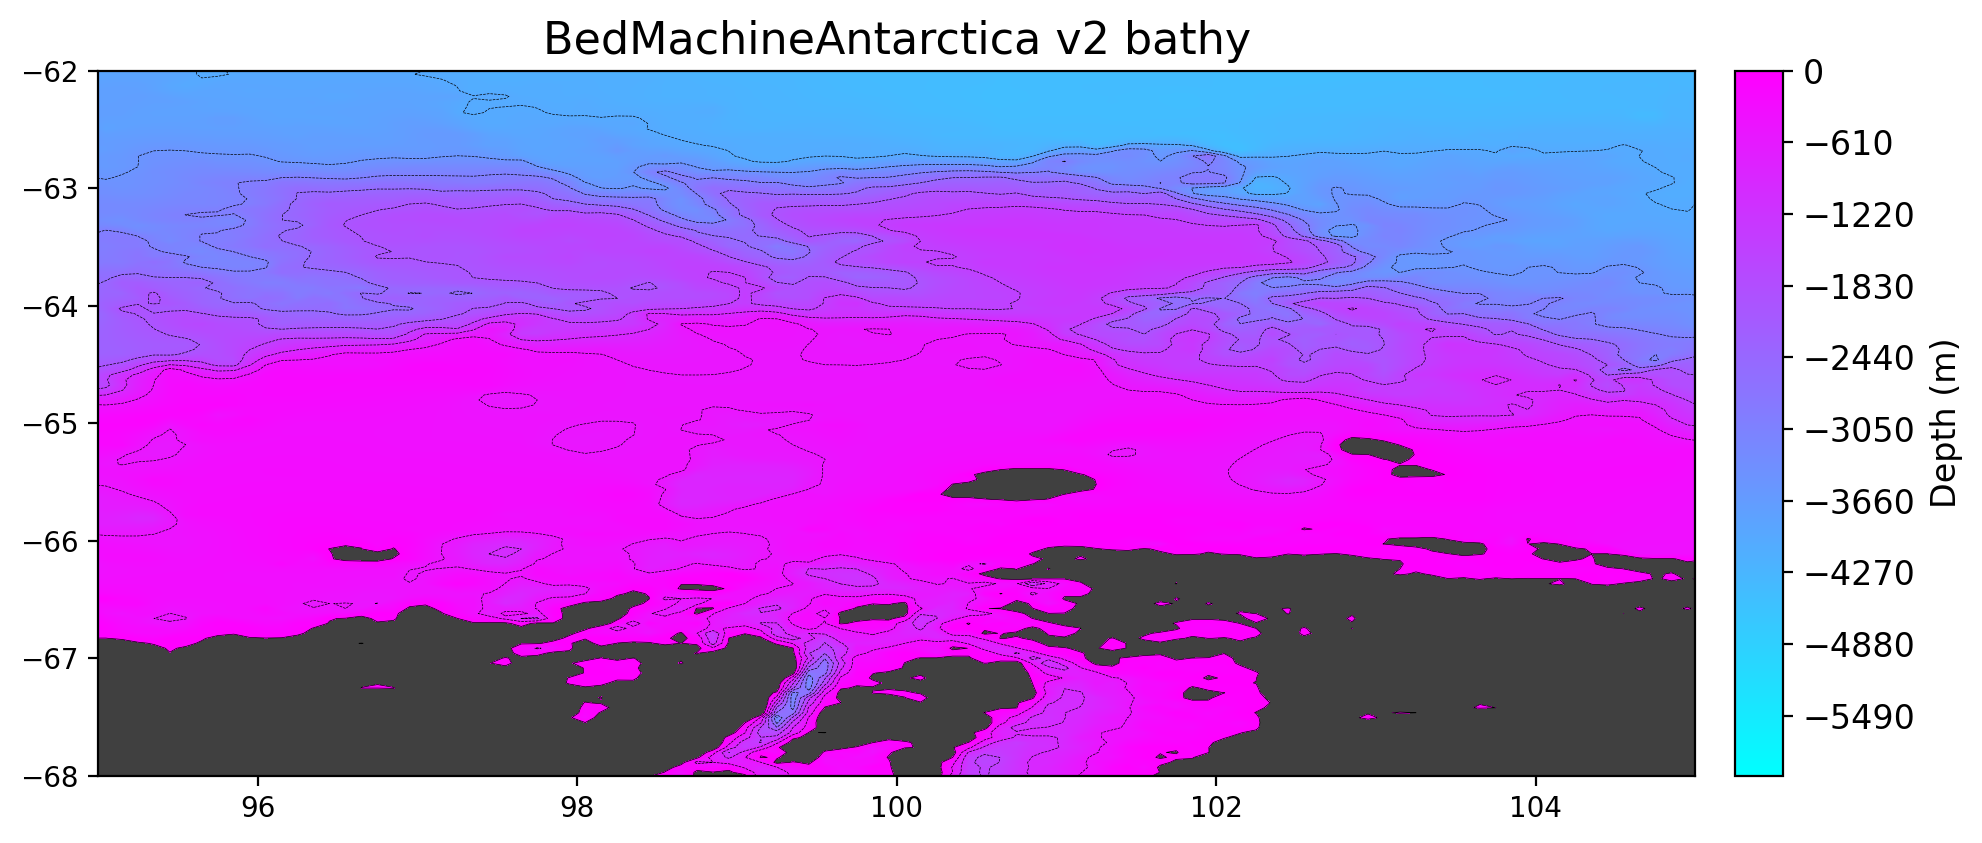

In [152]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def change_lon_space(ds, grid):
    if grid == 'u':
        #ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xu_ocean'] < 0, ds['xu_ocean'] + 360, ds['xu_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])

        ds = ds.swap_dims({'xu_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xu_ocean')
        ds = ds.rename({'_lon_adj': 'xu_ocean'})
    elif grid == 't':
        #ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        
        #for 0-360
        ds['_lon_adj'] = xr.where(ds['xt_ocean'] < 0, ds['xt_ocean'] + 360, ds['xt_ocean'])
        #do this line as well if want to switch to -180 to 180
        ds['_lon_adj'] = xr.where(ds['_lon_adj'] >180, ds['_lon_adj'] - 360, ds['_lon_adj'])
        
        ds = ds.swap_dims({'xt_ocean': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('xt_ocean')
        ds = ds.rename({'_lon_adj': 'xt_ocean'})
    return ds

bedbathy=xr.open_mfdataset('/g/data/v45/pas561/bedmachineant/bathy_om2.nc',engine='netcdf4',decode_times=False)


bb=bedbathy.bed.load()+bedbathy.geoid.load()

bb=bb.rename({'lon': 'xt_ocean','lat': 'yt_ocean'})

bb = change_lon_space(bb, 't')



#plot using new lat lon coords .... stalls out
clev = np.arange(-6000,10,10)
clev2 = np.arange(-6000,500,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(bb.x,bb.y,bb,vmin=-1500, vmax=0,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.ylim([-68,-62])
plt.xlim([95,105])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

In [153]:
velocitymean = np.sqrt(SSH_station.ugos.mean('time')**2 + SSH_station.ugos.mean('time')**2)
umean = SSH_station.ugos.mean('time').data
vmean = SSH_station.vgos.mean('time').data

In [154]:
umean_feb_apr = SSH_station.ugos.groupby('time.month').mean().sel(month = slice(2,4)).mean('month')
vmean_feb_apr = SSH_station.vgos.groupby('time.month').mean().sel(month = slice(2,4)).mean('month')
velocitymean_feb_apr = np.sqrt(umean_feb_apr**2 + vmean_feb_apr**2)

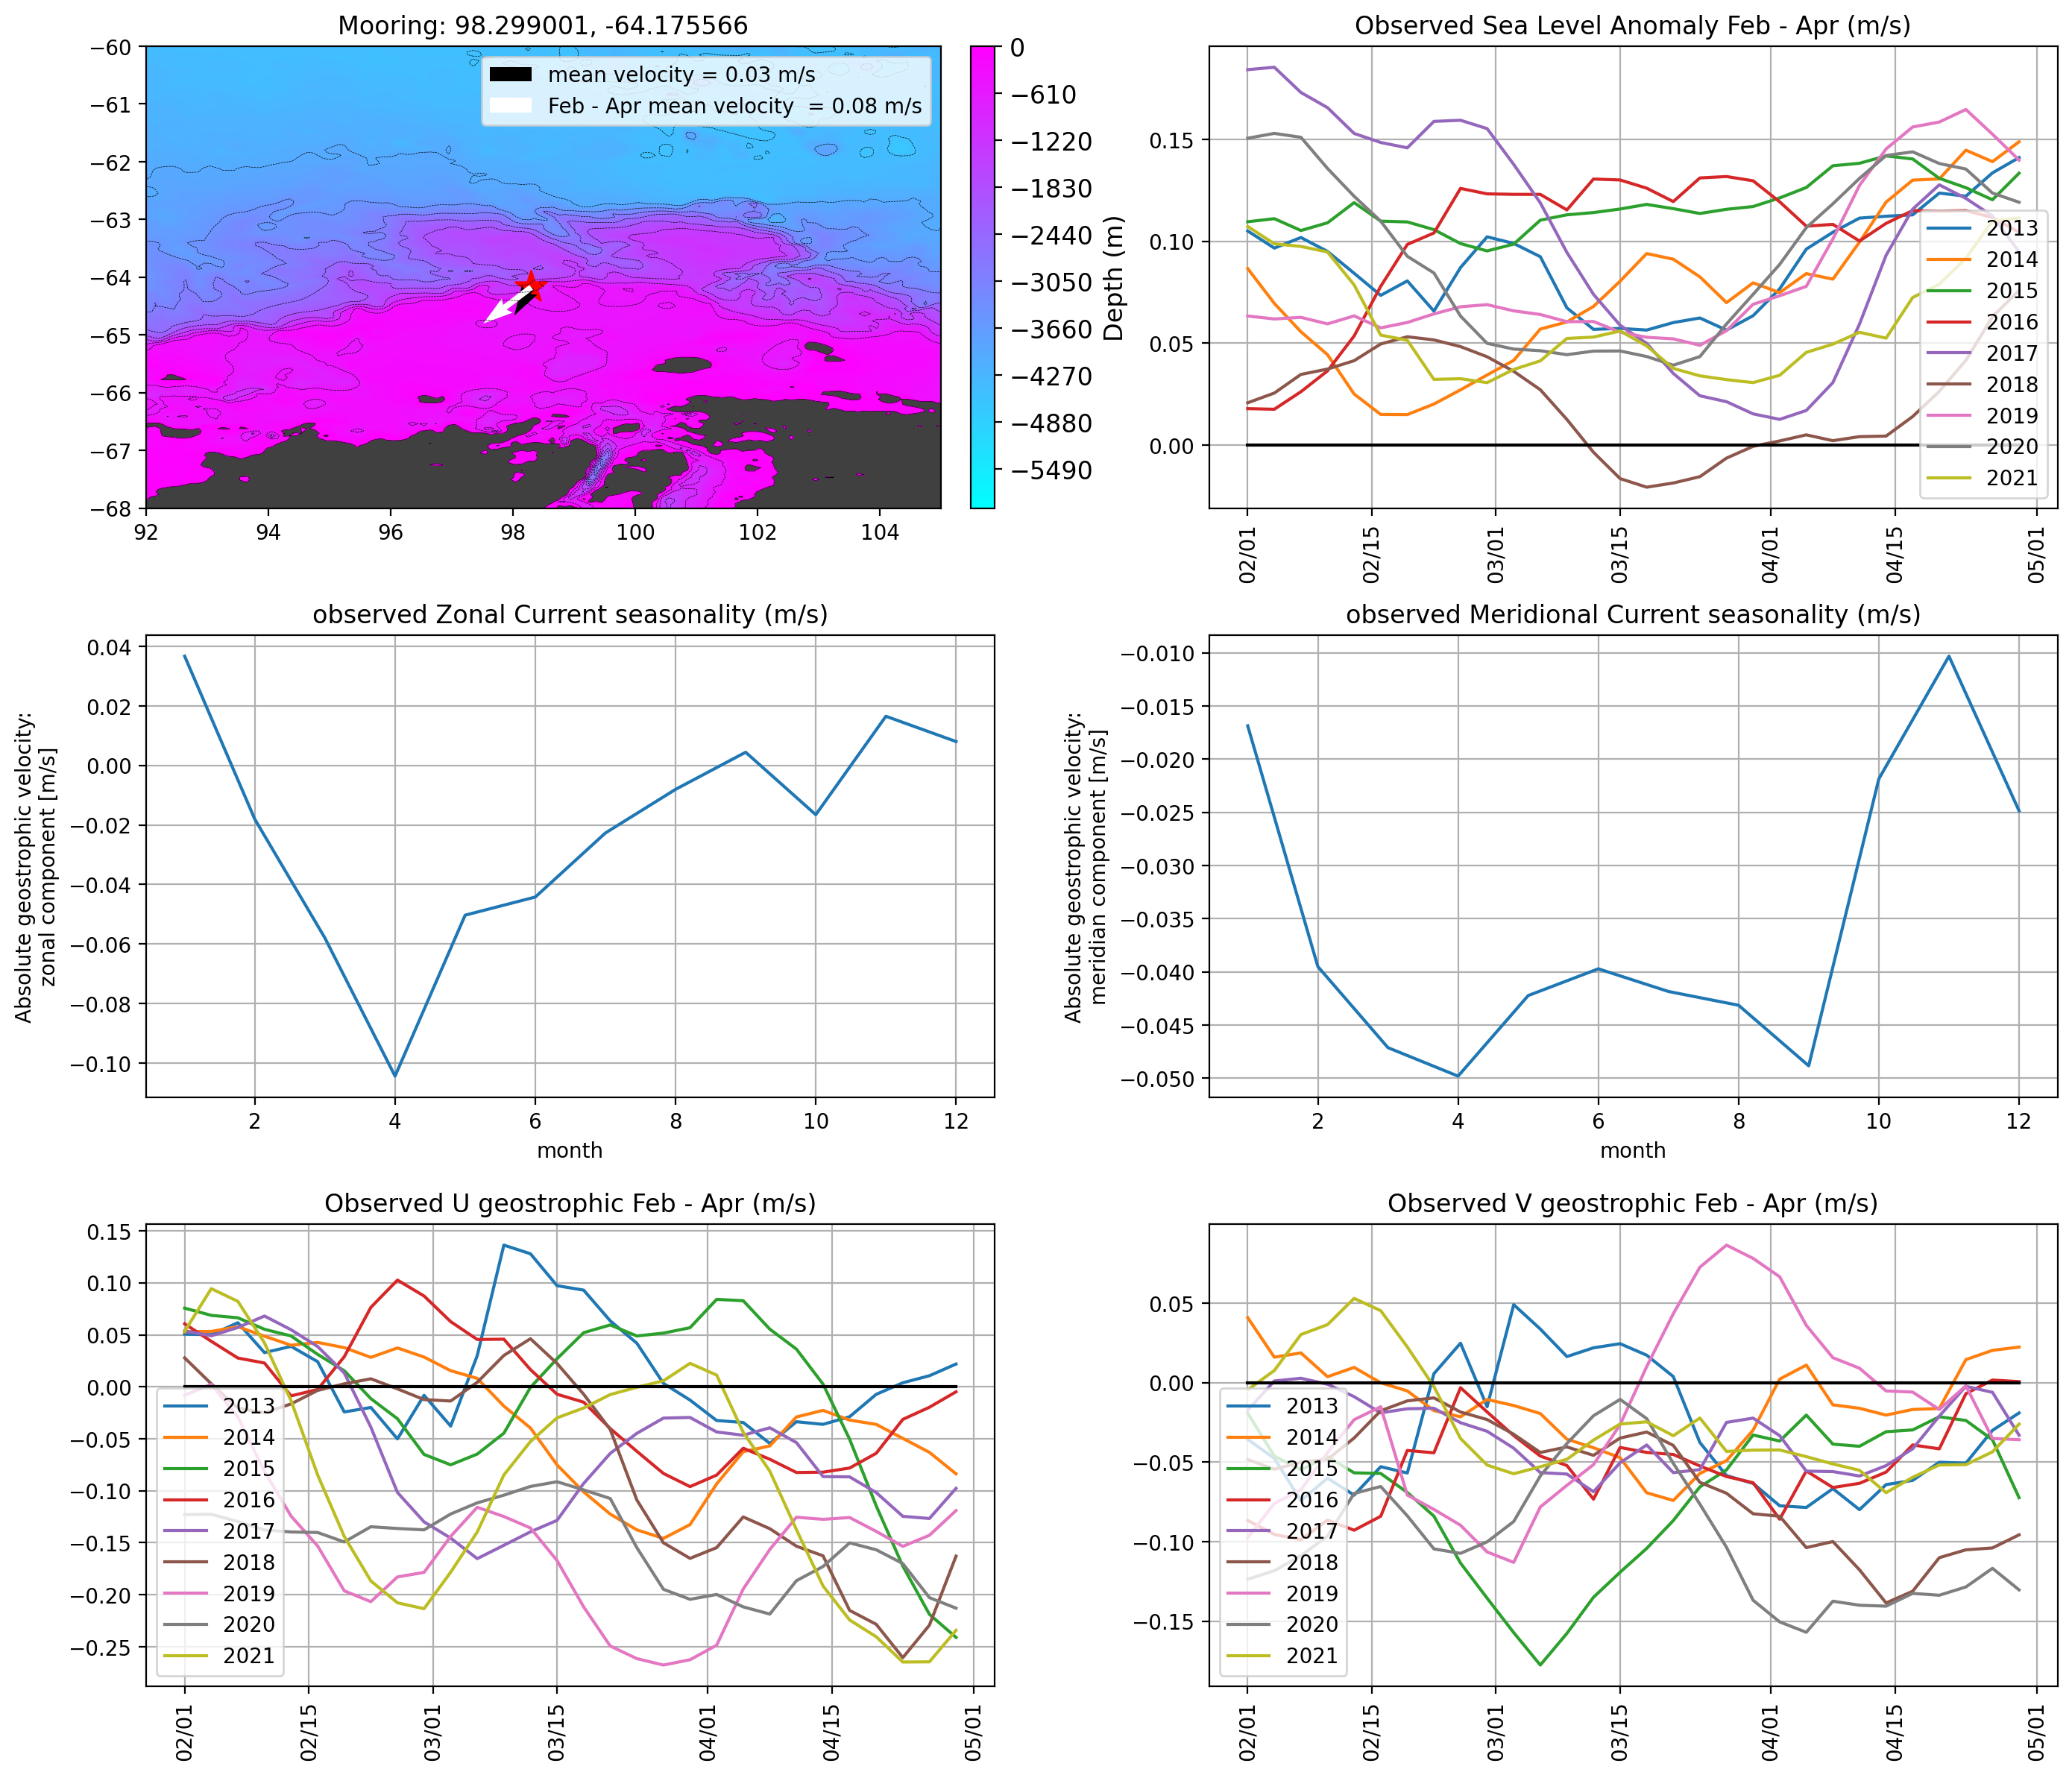

In [156]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m/%d')

plt.figure(figsize=(14,12))

plt.subplot(3,2,1)
plt.gca().patch.set_color('.25')
#p1=plt.pcolormesh(bb.x,bb.y,bb,vmin=-1500, vmax=0,cmap=plt.cm.cool)
p1=plt.contourf(bb.xt_ocean,bb.yt_ocean,bb,levels=clev,cmap=plt.cm.cool)
plt.contour(bb.xt_ocean,bb.yt_ocean,bb,levels=clev2,colors='k',linewidths=0.25)
plt.ylim([-68,-60])
plt.xlim([92,105])
plt.scatter(stations_array.Longitude.data[station_index],stations_array.Latitude.data[station_index], s = 250, color= 'red',marker='*')
plt.quiver(stations_array.Longitude.data[station_index],stations_array.Latitude.data[station_index], umean,vmean, scale = 1, label = 'mean velocity = %0.2f m/s' %float(velocitymean.data), color = 'k')
plt.quiver(stations_array.Longitude.data[station_index],stations_array.Latitude.data[station_index], umean_feb_apr,vmean_feb_apr, scale = 1, label = 'Feb - Apr mean velocity  = %0.2f m/s' %float(velocitymean_feb_apr.data), color = 'w')

plt.legend()

# plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
plt.title( "%s: %s, %s" %(station_type.to_numpy().tolist(),station_coordinates[0], station_coordinates[1]))

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

ax = plt.subplot(3,2,2)
ref = SSH_station.time.sel(time = slice(datetime.datetime(2013,2,1),datetime.datetime(2013,5,1)))
for y in range(2013,2022):
    datemin = datetime.datetime(y,2,1)
    datemax = datetime.datetime(y,5,1)
    SSH_station_y = SSH_station.sla.sel(time = slice(datemin,datemax)).to_numpy()
    if len(SSH_station_y) == 30:
        ax.plot(ref, SSH_station_y, label = "%s" %y )
    if len(SSH_station_y) == 31:
        ax.plot(ref, SSH_station_y[:-1], label = "%s" %y )
ax.plot(ref, np.zeros(ref.shape), color = 'k')

ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.title('Observed Sea Level Anomaly Feb - Apr (m/s)')    

plt.subplot(3,2,3)
SSH_station.ugos.groupby('time.month').mean().plot()
plt.grid()
plt.title('observed Zonal Current seasonality (m/s)')    


plt.subplot(3,2,4)
SSH_station.vgos.groupby('time.month').mean().plot()
plt.grid()
plt.title('observed Meridional Current seasonality (m/s)')    


ax = plt.subplot(3,2,5)
ref = SSH_station.time.sel(time = slice(datetime.datetime(2013,2,1),datetime.datetime(2013,5,1)))
for y in range(2013,2022):
    datemin = datetime.datetime(y,2,1)
    datemax = datetime.datetime(y,5,1)
    SSH_station_y = SSH_station.ugos.sel(time = slice(datemin,datemax)).to_numpy()
    if len(SSH_station_y) == 30:
        ax.plot(ref, SSH_station_y, label = "%s" %y )
    if len(SSH_station_y) == 31:
        ax.plot(ref, SSH_station_y[:-1], label = "%s" %y )
ax.plot(ref, np.zeros(ref.shape), color = 'k')

plt.grid()

ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=90)
plt.legend()
plt.title('Observed U geostrophic Feb - Apr (m/s)')    

ax = plt.subplot(3,2,6)
ref = SSH_station.time.sel(time = slice(datetime.datetime(2013,2,1),datetime.datetime(2013,5,1)))
for y in range(2013,2022):
    datemin = datetime.datetime(y,2,1)
    datemax = datetime.datetime(y,5,1)
    SSH_station_y = SSH_station.vgos.sel(time = slice(datemin,datemax)).to_numpy()
    if len(SSH_station_y) == 30:
        ax.plot(ref, SSH_station_y, label = "%s" %y )
    if len(SSH_station_y) == 31:
        ax.plot(ref, SSH_station_y[:-1], label = "%s" %y )
ax.plot(ref, np.zeros(ref.shape), color = 'k')
plt.title('Observed V geostrophic Feb - Apr (m/s)')    
ax.xaxis.set_major_formatter(myFmt)
plt.xticks(rotation=90)
plt.legend()
plt.grid()
plt.tight_layout()
